[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/figs.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/figs.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/figs.ipynb)

## Paweł Magnuszewski MSc project

## arithmetic Asian call valuation

we aim to price the arithmetic Asian call option using the MPDATA solver, by solving the following PDE:
$$  \frac{\partial f}{\partial t} + rS \frac{\partial f}{\partial S} + \frac{\sigma^2}{2} S^2 \frac{\partial^2 f}{\partial S^2} + \frac{S}{T}\frac{\partial f}{\partial A} - rf = 0$$

### Figures: 1, 2

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
import os
import numpy as np
from matplotlib import pyplot, colors, colormaps, patches
from open_atmos_jupyter_utils import show_plot
from PyMPDATA import Options
from PyMPDATA_examples.Magnuszewski_et_al_2025.asian_option import AsianArithmetic, Settings
from PyMPDATA_examples.Magnuszewski_et_al_2025.monte_carlo import BSModel, FixedStrikeArithmeticAsianOption
from PyMPDATA_examples.utils.financial_formulae import Black_Scholes_1973
import PyMPDATA_examples.utils.financial_formulae.asian_option as asian_analytic

In [3]:
OPTIONS = {
    "UPWIND": Options(
        n_iters=1,
        non_zero_mu_coeff=True,
    ),
    "MPDATA": Options(
        n_iters=3,
        nonoscillatory=True,
        non_zero_mu_coeff=True,
    )
}

RESOLUTION = {
    'nt': 500 if 'CI' not in os.environ else 50,
    'nx': 21 if 'CI' not in os.environ else 10,
    'ny': 31 if 'CI' not in os.environ else 10,
}

SETTINGS = Settings(
    T=1,
    K=100,
    r=.08,
    sgma=.4,
    S_max=200,
    S_min=50,
)

In [4]:
output = {k:[] for k in OPTIONS}
simulation = None
for key, opts in OPTIONS.items():
    simulation = AsianArithmetic(SETTINGS, **RESOLUTION, options=opts, variant='call')
    for n_steps in (0, RESOLUTION['nt'] // 2, RESOLUTION['nt'] - RESOLUTION['nt'] // 2):
        simulation.step(n_steps)
        output[key].append(simulation.solver.advectee.get().copy())

In [5]:
# calculate the arithmetic Asian option price by Monte Carlo for the same spot prices
arithmetic_by_mc = np.zeros_like(simulation.S)
for idx, spot in enumerate(simulation.S):
    model = BSModel(spot, SETTINGS.r, SETTINGS.sgma, SETTINGS.T, 1000 if 'CI' not in os.environ else 100)
    arithmetic_option = FixedStrikeArithmeticAsianOption(SETTINGS.T, SETTINGS.K, 'call', model,  100000 if 'CI' not in os.environ else 10000)
    arithmetic_by_mc[idx], _  = arithmetic_option.price_by_mc()

In [6]:
ax2_functions=(
    lambda x: np.interp(x, simulation.S, np.arange(len(simulation.S))+.5),
    lambda x: np.interp(x, np.arange(len(simulation.S))+.5, simulation.S)
)

In [7]:
xlim=(95, 155)
ylim=(5, 65)

### Figure 1 - advectee field dynamics

in this section we aim to:
- calculate the arithmetic Asian call option price using the MPDATA solver
- extract the advector field from the solver
- extract the advectee field from the solver at T=T, t=T/2, t=0 timesteps
- put all the above on the 4 plots

In [50]:
ax2_y_functions = (
    lambda x: np.exp(x*simulation.dx + np.log(simulation.settings.S_min)),
    lambda x: (np.log(x+10e-5) - np.log(simulation.settings.S_min))/ simulation.dx
)

ax2_x_functions = (
    lambda x: np.interp(x, np.arange(len(simulation.A))+.5, simulation.A),
    lambda x: np.interp(x, simulation.A, np.arange(len(simulation.A))+.5)
)

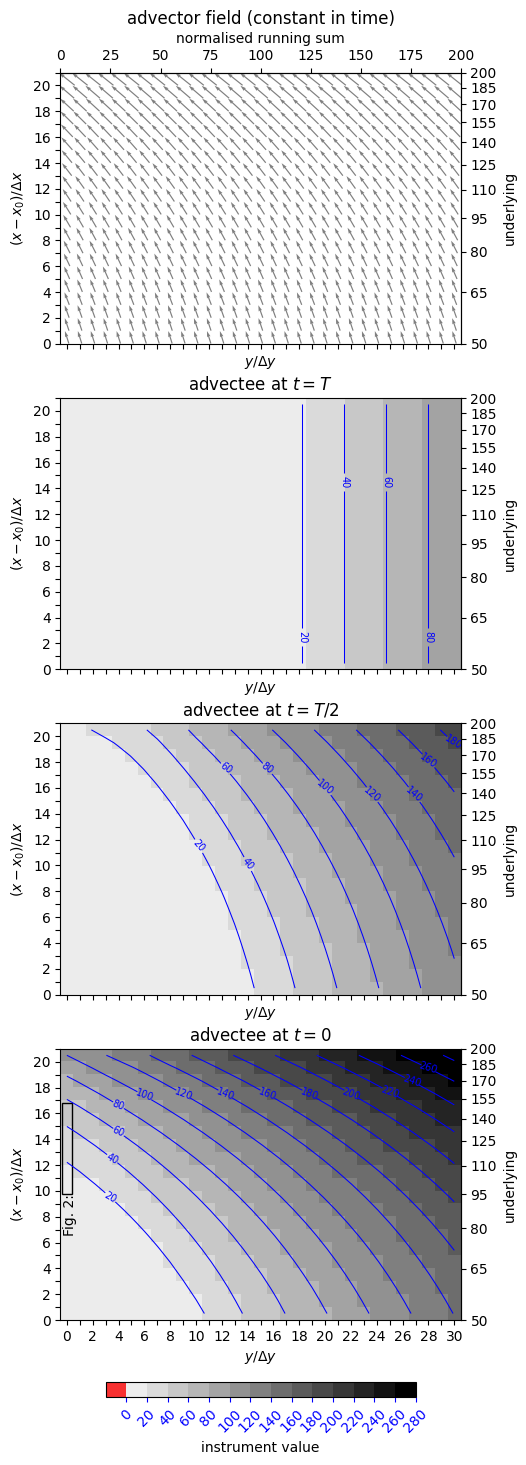

In [61]:
fig, axs = pyplot.subplots(4, 1, figsize=(10, 20), sharex=True, sharey=True)

# approximate advectors at cell centers
X = simulation.solver.advector.get_component(0)
X = (X[1:,:] + X[:-1,:])/2
Y = simulation.solver.advector.get_component(1)
Y = (Y[:,1:] + Y[:,:-1])/2

grid = (X.shape[1], Y.shape[0])
scale_x, scale_y = np.amax(np.abs(X)), np.amax(np.abs(Y))
imshow_common = {
    'origin': 'lower',
    'extent': (-.5, grid[0]-.5, 0, grid[1]),
}
cell_centers = np.mgrid[
    0 : grid[0] - 1/2 : 1,
    1/2 : grid[1] : 1,
]

im = axs[0].imshow(np.full(grid, np.nan), **imshow_common)
axs[0].quiver(*cell_centers, Y.T.flatten()/0.8/scale_y, X.T.flatten()/scale_x, 
    pivot='mid', 
    color='gray', 
    width=.003,
    scale=8, 
    scale_units='inches'
)
axs[0].set(
    title="advector field (constant in time)",
)

vmax = 280
assert .9 * vmax < np.amax(output["MPDATA"][-1]) < 1.1 * vmax

n_colors = 15
quantized_copper = colormaps['binary'].resampled(n_colors)
newcolors = quantized_copper(np.linspace(0, 1, n_colors))
pink = np.array([248/256, 48/256, 48/256, 1])
newcolors[:1, :] = pink
cmap = colors.ListedColormap(newcolors)
levels=np.linspace(-1/(n_colors-1), vmax, n_colors)

for i, title in enumerate(("advectee at $t=T$", "advectee at $t=T/2$", "advectee at $t=0$")):
    im = axs[i + 1].imshow(
        output["MPDATA"][i],
        cmap=cmap,
        interpolation='nearest',
        norm=colors.Normalize(vmin=-1/(n_colors-1) * vmax, vmax=vmax),
        **imshow_common,
    )
    axs[i + 1].clabel(
        axs[i + 1].contour(
            *np.meshgrid(
                np.linspace(0, grid[0]-1, grid[0]),
                np.linspace(.5, grid[1]-.5, grid[1])
            ),
            output["MPDATA"][i], levels, colors='blue', linewidths=.75,
        ),
        inline=.5,
        fontsize=7
    )
    axs[i + 1].set_title(title)
pyplot.colorbar(
    im, ax=axs, shrink=.4, pad=.04, label='instrument value', orientation="horizontal", ticks=abs(levels)
).ax.tick_params(rotation=45, color='blue', labelcolor='blue')

for ax in axs:
    ax.set_xticks(range(grid[0]+1), ["" if i%2!=0 else f"{i}" for i in range(grid[0]+1)])
    ax.set_yticks(range(grid[1]+1), ["" if i%2!=0 else f"{i}" for i in range(grid[1]+1)])
    ax.set(
        xlabel='$y/Δy$',
        ylabel='$(x-x_0)/Δx$',
        xlim=(-.5, grid[0]-.5),
    )
axs[-1].add_patch(patches.Rectangle(
    (-.4, ax2_functions[0](xlim[0])),
    .8,
    ax2_functions[0](xlim[1])-ax2_functions[0](xlim[0]),
    linewidth=1,
    edgecolor='black',
    facecolor='none'
))
axs[-1].annotate("Fig. 2:", (-.333, ax2_functions[0](xlim[0])-3), color='black', rotation=90)

twin_y = [axs[i].secondary_yaxis('right', functions=ax2_y_functions) for i in range(4)]
for ax in twin_y:
    ax.set(ylabel="underlying")
    # set ticks as every second value from simulation.S
    ax.set_yticks(np.linspace(simulation.settings.S_min, simulation.settings.S_max, 11), )
    # ax.set_yticks(range(grid[1]+1), ["" if i%2!=0 else f"{i}" for i in range(grid[1]+1)])

twin_x = axs[0].secondary_xaxis('top', functions=ax2_x_functions)
twin_x.set(xlabel="normalised running sum")

show_plot('advectee_over_time.pdf', inline_format='png')

### Figure 2

in this section we aim to: 
- calculate the arithmetic Asian call option price using the MPDATA solver 
- price the arithmetic Asian call option using the Monte Carlo method for the same spot prices
- calculate European call option price using the Black-Scholes formula for the same option parameters
- calculate geometric Asian call option price using the Kemna & Vorst formula for the same option parameters
- put all the above on the same plot

In [10]:
def plot_solution(
    settings,
    ax,
    output,
    S_linspace,
    arithmetic_by_mc,
    variant,
    s_space_edges,
    xlim,
    ylim,
    ax2_functions,
):
    euro_price_func = {
        "call": Black_Scholes_1973.c_euro,
        "put": Black_Scholes_1973.p_euro,
    }[variant]
    geometric_price_func = {
        "call": asian_analytic.geometric_asian_average_price_c,
        "put": asian_analytic.geometric_asian_average_price_p,
    }[variant]

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    # ranges for plotting
    s_indexes_within_range = range(len(S_linspace))
    clipped_s_space = S_linspace

    # plot European option price as a somewhat upper bound
    ax.plot(
        clipped_s_space,
        (
            euro_price_func(
                S=clipped_s_space, K=settings.K, T=settings.T, r=settings.r, b=settings.r, sgma=settings.sgma
            )
        ),
        label="European analytic (Black-Scholes '73)",
        linestyle=":",
        c="olive"
    )
    colors = {"UPWIND": "gray", "MPDATA": "black"}
    markers = {"UPWIND": ".", "MPDATA": "o"}
    for key, val in output.items():
        ax.bar(
            s_space_edges[:-1][s_indexes_within_range],
            val[:, 0][s_indexes_within_range],
            width=s_space_edges[1:][s_indexes_within_range] - s_space_edges[:-1][s_indexes_within_range],
            alpha=0.2,
            align="edge",
            color=colors[key]
        )
        ax.plot(
            clipped_s_space,
            val[:, 0][s_indexes_within_range],
            label=f"Asian arithmetic {key} solution",
            marker=markers[key],
            c=colors[key]
        )
    ax.plot(
        clipped_s_space,
        arithmetic_by_mc[s_indexes_within_range],
        label="Asian arithmetic by Monte-Carlo",
        marker="+",
        c="orange",
        linestyle="-.",
    )

    # plot Asian option price as a somewhat lower bound
    ax.plot(
        clipped_s_space,
        (
            geometric_price_func(
                S=clipped_s_space, K=settings.K, T=settings.T, r=settings.r, dividend_yield=0, sgma=settings.sgma
            )
        ),
        label="Asian geometric analytic (Kemna & Vorst '90)",
        linestyle="--",
        c="green"
    )
    ax2 = ax.secondary_xaxis('top', functions=ax2_functions)
    ax2.set(
        xlabel="$(x-x_0)/Δx$",
        xticks=s_indexes_within_range,
    )
    for tick in ax2.get_xticks():
        ax.axvline(ax2_functions[1](tick), color='lightgray', linestyle=':', linewidth=4)
    ax.set(
        xlabel="price of the underlying at t=0 (spot price)",
        ylabel="instrument value",
    )
    ax.legend(loc="lower right", handlelength=1.5)
    ax.grid()

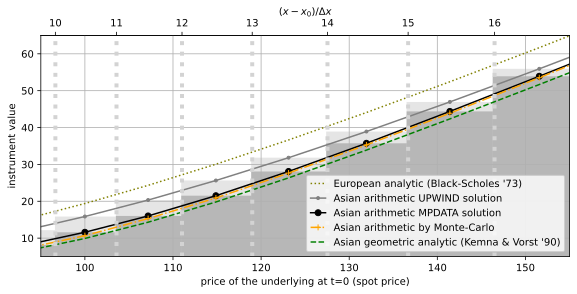

In [11]:
_, ax = pyplot.subplots(1, 1, figsize=(9.5, 4))

plot_solution(
    settings=SETTINGS,
    ax=ax,
    output={k:v[-1] for k,v in output.items()},
    arithmetic_by_mc=arithmetic_by_mc,
    S_linspace=simulation.S,
    variant='call',
    s_space_edges=np.exp(np.linspace(
        np.log(simulation.S[0]) - simulation.dx/2,
        np.log(simulation.S[-1]) + simulation.dx/2,
        RESOLUTION['nx'] + 1
    )),
    xlim=xlim,
    ylim=ylim,
    ax2_functions=ax2_functions,
)
show_plot('numeric_vs_analytic.pdf')